In [1]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader, Galaxy

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt

import numpy as np
import pickle
from tqdm import trange
import seaborn as sns
sns.set_context("paper", font_scale=1.5)

# Load mm object from the file
#filename = "morphmodel.pkl"
#filename = "2dmorphmodel400.pkl"
#with open(filename, "rb") as file:


#    mm = pickle.load(file)

In [2]:
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5", m_min = 8)


File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))


In [3]:
norm = image.norm # Normalization function
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.25, "upper": upper},
                    
}


In [4]:
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_function_kwargs
Created datamatrix with shape:  (12484, 12288)


In [5]:
mm.fit(n_components = 60,show_results = False)

In [6]:
original = mm.get_images()
eigengalaxies = mm.get_eigengalaxies()
means = mm.get_means()
scores = mm.scores
pca_projection = mm.inverse_transformed_datamatrix.reshape(original.shape)

In [9]:
from pyppca import ppca
from sklearn.impute import SimpleImputer

In [10]:
norm_data = mm.datamatrix.copy()

In [65]:
np.random.seed(22)
cens_data=norm_data.copy()
indexes = np.arange(len(norm_data))
miss_rows_idx=np.random.choice(indexes,int(len(norm_data)/20),replace=False)

In [15]:
miss_field_idx=np.random.choice(np.arange(3),len(indexes),replace=True)

In [33]:
SHAPE = (3,64,64)


In [66]:
for i in miss_rows_idx:
    d=cens_data[indexes==i].copy().reshape(SHAPE)
    off=np.random.choice([0,1,2],1)
    d[off,:,:]=np.nan
    cens_data[indexes==i]=d.flatten()

In [67]:
C,ss,M,X,y_ppca=ppca(cens_data,10,False)

In [68]:
inc_idx=np.isin(indexes,miss_rows_idx)
y_ppca=y_ppca[inc_idx]

In [69]:
norm_samp=norm_data[inc_idx]
cens_samp=cens_data[inc_idx]
miss_rows_samp=np.random.choice(range(0,len(norm_samp)),20,replace=False)

In [70]:

og = norm_samp[miss_rows_samp]
cens = cens_samp[miss_rows_samp]
rec = y_ppca[miss_rows_samp]





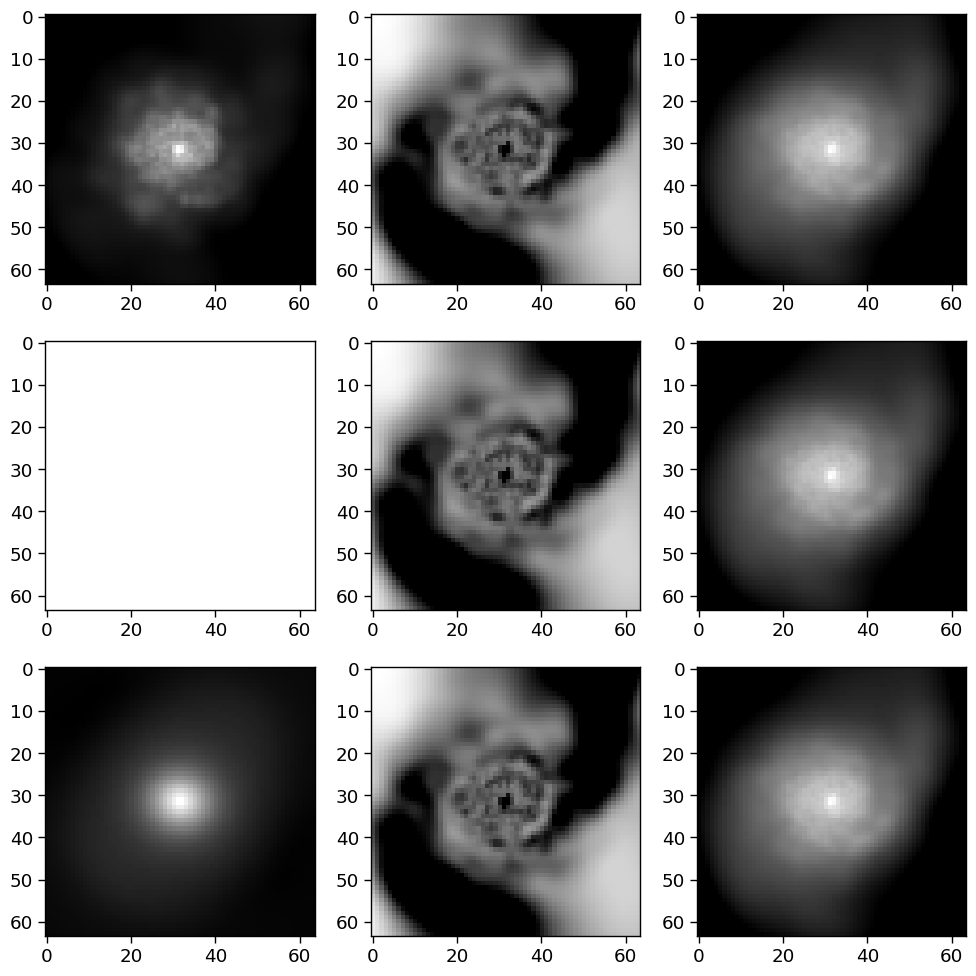

In [83]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
index = 19
for i in range(3):
    ax[0,i].imshow(og[index].reshape(SHAPE)[i], cmap="gray")
    ax[1,i].imshow(cens[index].reshape(SHAPE)[i], cmap="gray")
    ax[2,i].imshow(rec[index].reshape(SHAPE)[i], cmap="gray")

plt.tight_layout()